<a href="https://colab.research.google.com/github/Lucs1590/study_segmentation/blob/main/panoptic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Panoptic Segmentation

- We will use Detectron2 developed in PyTorch by [FAIR](https://ai.facebook.com/) (*Facebook AI Research*). We also will use DETR (DEtection TRansformer) to object detection task.

### Detectron2
- https://ai.facebook.com/tools/detectron2/ 
- [Github repository](https://github.com/facebookresearch/Detectron2)
## DETR
- https://arxiv.org/pdf/2005.12872.pdf 

# Libs import

In [ ]:
import io
import cv2
import math
import matplotlib.pyplot as plt
import requests
from PIL import Image

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
from copy import deepcopy
from google.colab.patches import cv2_imshow
torch.set_grad_enabled(False);

In [ ]:
#!pip install torch==1.9.0 torchvision==0.10.0
#import torch; print(torch.__version__)  #mostra versão
#!python -m pip install pip==21.3
#!pip --version #mostra versão

In [ ]:
!pip install git+https://github.com/cocodataset/panopticapi.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-y88qoq35
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-y88qoq35
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8306 sha256=2a60ceb949d1cbcac09ce58643808320fa088385363af346d597a072b0ee12b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-kg3o0zxy/wheels/ad/89/b8/b66cce9246af3d71d65d72c85ab993fd28e7578e1b0ed197f1
Successfully built panopticapi


In [ ]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id

In [ ]:
!git clone https://github.com/facebookresearch/detectron2.git
!pip install ./detectron2
!pip install --upgrade pyyaml

Cloning into 'detectron2'...
remote: Enumerating objects: 14474, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 14474 (delta 18), reused 32 (delta 13), pack-reused 14425
Receiving objects: 100% (14474/14474), 5.93 MiB | 12.54 MiB/s, done.
Resolving deltas: 100% (10463/10463), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./detectron2
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 50 kB 4.7 MB/s 
     |████████████████████████████████| 79 kB 7.3 MB/s 
     |████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r /content/gdrive/MyDrive/Cursos\ -\ recursos/Segmentação\ Imagens\ Python\ AZ/fotos fotos/

# Normalização

- Método padrão usado pelo Pytorch para normalização [mean-std](https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html)
- mean = [0.485, 0.456, 0.406] 
- std = [0.229, 0.224, 0.225]

In [ ]:
transform = T.Compose([T.Resize(800), T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
transform

Compose(
    Resize(size=800, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

# Carregamento da rede neural

In [ ]:
model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', pretrained=True, 
                                      return_postprocessor = True, num_classes=250)

Downloading: "https://github.com/facebookresearch/detr/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-panoptic-40021d53.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-panoptic-40021d53.pth


  0%|          | 0.00/237M [00:00<?, ?B/s]

In [ ]:
model

In [ ]:
postprocessor

PostProcessPanoptic()

# Preparação da imagem

In [ ]:
imagem = Image.open('fotos/pedestres04.jpg')
print(imagem)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x999 at 0x7F8AEFE3A750>


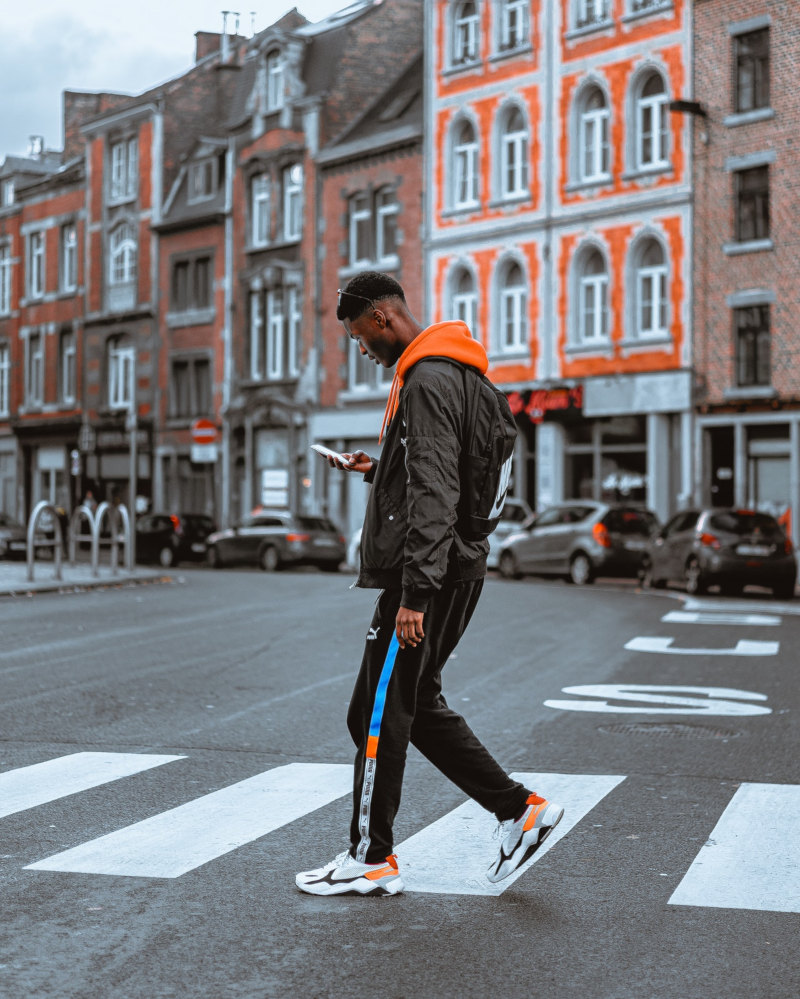

In [ ]:
imagem

In [ ]:
imagem.getpixel((0,0))

(232, 243, 249)

In [ ]:
img = transform(imagem).unsqueeze(0)

In [ ]:
img

tensor([[[[ 1.8550,  1.8550,  1.8550,  ...,  0.5193,  0.3481,  0.2796],
          [ 1.8550,  1.8550,  1.8550,  ...,  0.3652,  0.4337,  0.4679],
          [ 1.8550,  1.8550,  1.8550,  ...,  0.6221,  0.7933,  0.8618],
          ...,
          [ 0.0569,  0.1597,  0.1939,  ..., -0.3198, -0.2856, -0.4226],
          [ 0.0227,  0.1083,  0.0569,  ..., -0.2856, -0.2342, -0.3369],
          [-0.0116,  0.1083,  0.0569,  ..., -0.3883, -0.3198, -0.4568]],

         [[ 2.2185,  2.2185,  2.2185,  ...,  0.5028,  0.3277,  0.2577],
          [ 2.2185,  2.2185,  2.2185,  ...,  0.2402,  0.3102,  0.3452],
          [ 2.2185,  2.2185,  2.2185,  ...,  0.3978,  0.5728,  0.6429],
          ...,
          [ 0.4678,  0.5728,  0.6078,  ..., -0.1099, -0.0749, -0.2150],
          [ 0.4678,  0.5203,  0.4678,  ..., -0.1099, -0.0574, -0.1625],
          [ 0.4328,  0.5553,  0.4678,  ..., -0.2500, -0.1800, -0.3200]],

         [[ 2.5354,  2.5354,  2.5354,  ...,  0.5659,  0.4265,  0.3568],
          [ 2.5354,  2.5354,  

# Segmentação

In [ ]:
out = model(img)

/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [ ]:
out

{'pred_boxes': tensor([[[0.6328, 0.2306, 0.4468, 0.2879],
          [0.9131, 0.4818, 0.0644, 0.0806],
          [0.4320, 0.2694, 0.8421, 0.3387],
          [0.1287, 0.5403, 0.2561, 0.0912],
          [0.4250, 0.5422, 0.0458, 0.0531],
          [0.5913, 0.8356, 0.2345, 0.1197],
          [0.9165, 0.4666, 0.0663, 0.0789],
          [0.0293, 0.5367, 0.0575, 0.0540],
          [0.5000, 0.4988, 0.9982, 0.9987],
          [0.6382, 0.5320, 0.0583, 0.0634],
          [0.0980, 0.5418, 0.1725, 0.0874],
          [0.5000, 0.2849, 0.9981, 0.5691],
          [0.9420, 0.2157, 0.0583, 0.1701],
          [0.6162, 0.5537, 0.7115, 0.0847],
          [0.6345, 0.5343, 0.0458, 0.0507],
          [0.3553, 0.1760, 0.0678, 0.0760],
          [0.5580, 0.8402, 0.2392, 0.1126],
          [0.5000, 0.7727, 0.9981, 0.4506],
          [0.6385, 0.2643, 0.6840, 0.5237],
          [0.2401, 0.1972, 0.4790, 0.3934],
          [0.4317, 0.2617, 0.8584, 0.5240],
          [0.3901, 0.5301, 0.0994, 0.0507],
          [0.7185,

In [ ]:
out['pred_logits'].size()

torch.Size([1, 100, 251])

In [ ]:
scores = out['pred_logits'].softmax(-1)[...,:-1].max(-1)[0]

In [ ]:
scores

tensor([[0.0081, 0.0081, 0.0318, 0.0051, 0.0153, 0.0166, 0.0463, 0.1545, 0.0022,
         0.1230, 0.1526, 0.9720, 0.0305, 0.0030, 0.8807, 0.0030, 0.0347, 0.9925,
         0.0076, 0.0178, 0.0194, 0.0087, 0.0020, 0.0059, 0.0089, 0.0045, 0.0060,
         0.0424, 0.0278, 0.0054, 0.9540, 0.2269, 0.0487, 0.0081, 0.0442, 0.0076,
         0.2758, 0.0291, 0.0051, 0.0051, 0.0057, 0.9997, 0.0169, 0.9992, 0.0086,
         0.2483, 0.0388, 0.0083, 0.0142, 0.0030, 0.1842, 0.0351, 0.0018, 0.9102,
         0.0426, 0.0145, 0.2988, 0.0073, 0.0092, 0.3338, 0.0212, 0.0174, 0.0212,
         0.0025, 0.0359, 0.0163, 0.1195, 0.0021, 0.0059, 0.9786, 0.0156, 0.0075,
         0.0112, 0.0514, 0.0016, 0.0197, 0.0085, 0.0074, 0.0725, 0.0125, 0.9990,
         0.0442, 0.0075, 0.9203, 0.0318, 0.9997, 0.0306, 0.0067, 0.2822, 0.0856,
         0.0137, 0.0051, 0.0188, 0.0440, 0.0018, 0.0847, 0.0088, 0.0513, 0.0447,
         0.9930]])

# Retorno das máscaras

In [ ]:
keep = scores > 0.85
print(keep)

tensor([[False, False, False, False, False, False, False, False, False, False,
         False,  True, False, False,  True, False, False,  True, False, False,
         False, False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False, False,
         False,  True, False,  True, False, False, False, False, False, False,
         False, False, False,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False, False,
          True, False, False,  True, False,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False,  True]])


In [ ]:
math.ceil(keep.sum().item() / 5)

3

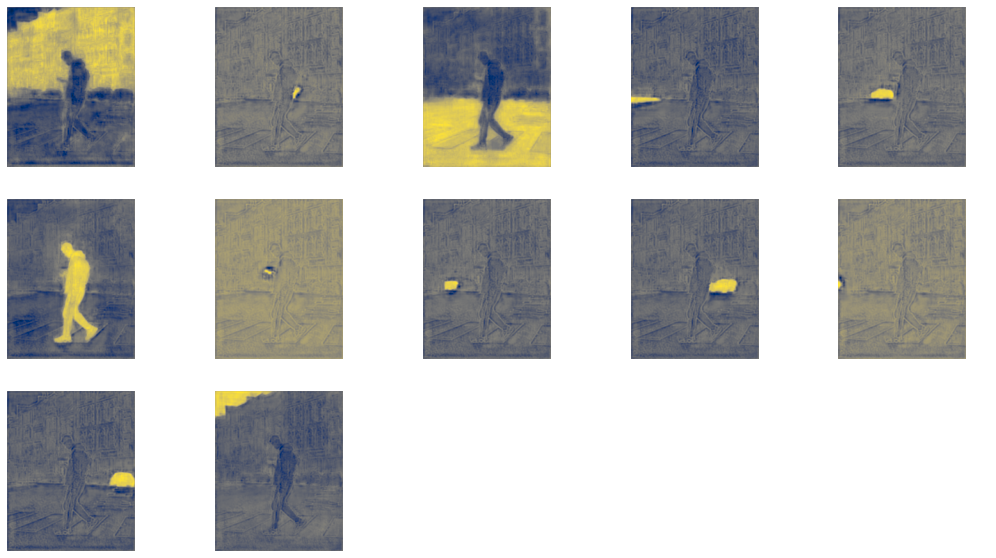

In [ ]:
n_colunas = 5
fig, axs = plt.subplots(ncols=n_colunas, nrows=math.ceil(keep.sum().item() / n_colunas), figsize=(18,10))
for line in axs:
  for a in line:
    a.axis('off')
for i, mask in enumerate(out['pred_masks'][keep]):
  ax = axs[i // n_colunas, i % n_colunas]
  ax.imshow(mask, cmap='cividis')
  ax.axis('off')

# Unificação dos segmentos

In [ ]:
img.shape, img.shape[-2:], torch.as_tensor(img.shape[-2:]).unsqueeze(0)[0]

(torch.Size([1, 3, 999, 800]), torch.Size([999, 800]), tensor([999, 800]))

In [ ]:
resultado = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
resultado

{'png_string': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x03\xe7\x08\x02\x00\x00\x00X\xff\xbf3\x00\x00"xIDATx\x9c\xed\xdd\xe9v\x1b\xc9\x91\x80\xd1\xa2Zr\xf7\xd8\xef\xff\xa8\x9eq\xb7,y~\x80&!,\x85Z"\xb7\xc8{\x8f\x8f\x8f\xa4\xa6\xc8\x02@V}\x8aL\x00o\xffX\x00\x9e\xfag\xeb\x03\x00\x18\xd1\x97\xd6\x07\x00\x00\x90\x8d\xc0\x02\x00\x08&\xb0\x80\xa7\xac\x0f\x02\x1c#\xb0\x80\xc7\xd4\x15\xc0a\x02\x0b\x00 \x98\xc0\x02\x1e0\xbe\x028\xe3k\xeb\x03\x00\xfa"\xad\x00\xce\x13X\xc0;i\x05\x10\xc5\x12!\xb0,\xea\n \x94\xc0\x02\xd4\x15@0\x81\x05\xb3SW\x00\xe1\xec\xc1\x82yI+\x80B\x04\x16\xd4s\x134\r\xdfj]Z\x01\x14e\x89\x10j\xf8\xe7\xa3\xa6iU9\xea\n\xa0\xb4\xb7\x86\xff\x86\x86\x19l\xa9\x99j?\x86\xd2\n\xa0\x0e\x81\x05\xa5\xec\xaa\x99\xa2?\x89\xba\n\xa02\x81\x05E\x1ck\x9a\xf0\x9fGi\x05\xd0\x84\xc0\x82x\'\xb3&\xe4\xa7RZ\x014$\xb0 R`\xd6\x1c\xfb\xd9\xd4U\x00=\x10X\x10\xa3P\xd9l\xfc\t\xd5U\x00]\x11XpV\x9d\xb8y\xf8\xa3\xaa\xab\x00\xfa$\xb0\xe0\x14\x89\x03\xc0=\xaf\xe4\x0e\x07I+\x00\x9e\x11X\xb0\x9b\x

In [ ]:
import itertools
import seaborn as sns
palette = itertools.cycle(sns.color_palette())

In [ ]:
seg_panoptica = Image.open(io.BytesIO(resultado['png_string']))
seg_panoptica = numpy.array(seg_panoptica, dtype=numpy.uint8).copy()
seg_panoptica_id = rgb2id(seg_panoptica)

In [ ]:
seg_panoptica_id.shape

(999, 800)

In [ ]:
import numpy as np

In [ ]:
seg_panoptica_id, np.unique(seg_panoptica_id, return_counts = True)

(array([[11, 11, 11, ...,  0,  0,  0],
        [11, 11, 11, ...,  0,  0,  0],
        [11, 11, 11, ...,  0,  0,  0],
        ...,
        [ 2,  2,  2, ...,  2,  2,  2],
        [ 2,  2,  2, ...,  2,  2,  2],
        [ 2,  2,  2, ...,  2,  2,  2]], dtype=int32),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32),
  array([363365,   1024, 299008,   4660,   6800,  71770,    473,   3852,
          10619,    530,  11512,  25587])))

(-0.5, 799.5, 998.5, -0.5)

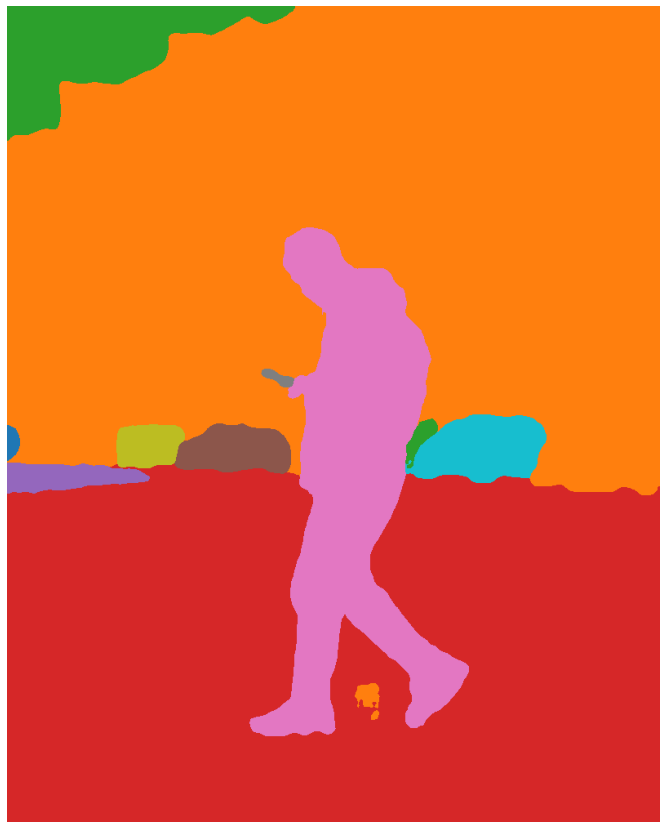

In [ ]:
seg_panoptica[:,:,:] = 0
for id in range(seg_panoptica_id.max() + 1):
  seg_panoptica[seg_panoptica_id == id] = numpy.asarray(next(palette)) * 255
plt.figure(figsize=(15,15))
plt.imshow(seg_panoptica)
plt.axis('off')

# Visualização final com Detectron2

In [ ]:
resultado['segments_info']

[{'area': 363365, 'category_id': 197, 'id': 0, 'isthing': False},
 {'area': 1024, 'category_id': 3, 'id': 1, 'isthing': True},
 {'area': 299008, 'category_id': 149, 'id': 2, 'isthing': False},
 {'area': 4660, 'category_id': 191, 'id': 3, 'isthing': False},
 {'area': 6800, 'category_id': 3, 'id': 4, 'isthing': True},
 {'area': 71770, 'category_id': 1, 'id': 5, 'isthing': True},
 {'area': 473, 'category_id': 77, 'id': 6, 'isthing': True},
 {'area': 3852, 'category_id': 3, 'id': 7, 'isthing': True},
 {'area': 10619, 'category_id': 3, 'id': 8, 'isthing': True},
 {'area': 530, 'category_id': 3, 'id': 9, 'isthing': True},
 {'area': 11512, 'category_id': 3, 'id': 10, 'isthing': True},
 {'area': 25587, 'category_id': 187, 'id': 11, 'isthing': False}]

In [ ]:
# https://en.wikipedia.org/wiki/Object_copying#:~:text=Deep%20copy%20is%20a%20process,is%20copied%20in%20other%20object.
info_segmentos = deepcopy(resultado['segments_info'])

In [ ]:
seg_panoptica = Image.open(io.BytesIO(resultado['png_string']))

In [ ]:
final_w, final_h = seg_panoptica.size
print(final_w, final_h)

800 999


In [ ]:
seg_panoptica = numpy.asarray(seg_panoptica, dtype=numpy.uint8)
seg_panoptica = torch.from_numpy(rgb2id(seg_panoptica))

In [ ]:
meta = MetadataCatalog.get('coco_2017_val_panoptic_separated')
for i in range(len(info_segmentos)):
  c = info_segmentos[i]['category_id']
  #print(c)
  info_segmentos[i]['category_id'] = meta.thing_dataset_id_to_contiguous_id[c] if info_segmentos[i]['isthing'] else meta.stuff_dataset_id_to_contiguous_id[c]

In [ ]:
info_segmentos

[{'area': 363365, 'category_id': 50, 'id': 0, 'isthing': False},
 {'area': 1024, 'category_id': 2, 'id': 1, 'isthing': True},
 {'area': 299008, 'category_id': 21, 'id': 2, 'isthing': False},
 {'area': 4660, 'category_id': 44, 'id': 3, 'isthing': False},
 {'area': 6800, 'category_id': 2, 'id': 4, 'isthing': True},
 {'area': 71770, 'category_id': 0, 'id': 5, 'isthing': True},
 {'area': 473, 'category_id': 67, 'id': 6, 'isthing': True},
 {'area': 3852, 'category_id': 2, 'id': 7, 'isthing': True},
 {'area': 10619, 'category_id': 2, 'id': 8, 'isthing': True},
 {'area': 530, 'category_id': 2, 'id': 9, 'isthing': True},
 {'area': 11512, 'category_id': 2, 'id': 10, 'isthing': True},
 {'area': 25587, 'category_id': 40, 'id': 11, 'isthing': False}]

In [ ]:
cores_classes = meta.stuff_colors
cores_classes

[[82, 18, 128],
 [255, 255, 128],
 [147, 211, 203],
 [150, 100, 100],
 [168, 171, 172],
 [146, 112, 198],
 [210, 170, 100],
 [92, 136, 89],
 [218, 88, 184],
 [241, 129, 0],
 [217, 17, 255],
 [124, 74, 181],
 [70, 70, 70],
 [255, 228, 255],
 [154, 208, 0],
 [193, 0, 92],
 [76, 91, 113],
 [255, 180, 195],
 [106, 154, 176],
 [230, 150, 140],
 [60, 143, 255],
 [128, 64, 128],
 [92, 82, 55],
 [254, 212, 124],
 [73, 77, 174],
 [255, 160, 98],
 [255, 255, 255],
 [104, 84, 109],
 [169, 164, 131],
 [225, 199, 255],
 [137, 54, 74],
 [135, 158, 223],
 [7, 246, 231],
 [107, 255, 200],
 [58, 41, 149],
 [183, 121, 142],
 [255, 73, 97],
 [107, 142, 35],
 [190, 153, 153],
 [146, 139, 141],
 [70, 130, 180],
 [134, 199, 156],
 [209, 226, 140],
 [96, 36, 108],
 [96, 96, 96],
 [64, 170, 64],
 [152, 251, 152],
 [208, 229, 228],
 [206, 186, 171],
 [152, 161, 64],
 [116, 112, 0],
 [0, 114, 143],
 [102, 102, 156],
 [250, 141, 255]]

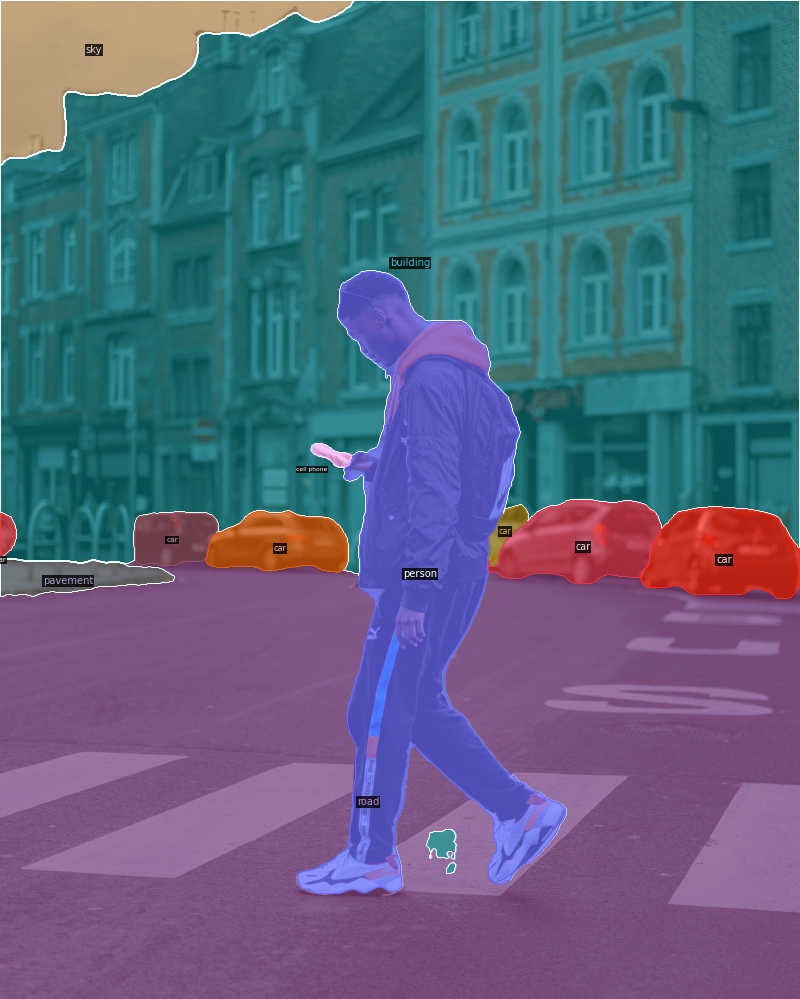

In [ ]:
v = Visualizer(numpy.array(imagem.copy().resize((final_w, final_h)))[:,:,::-1], meta, scale=1.0)
v = v.draw_panoptic_seg_predictions(seg_panoptica, info_segmentos)
resultado_final = v.get_image()
cv2_imshow(resultado_final)